In [ ]:
#Reference: https://towardsdatascience.com/intro-to-pytorch-2-convolutional-neural-networks-487d8a35139a

In [ ]:
# Dependencies
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision import utils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
torch.cuda.get_device_name(0) # Shows what GPU I have access to

'Tesla T4'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
torch.manual_seed(42) # set a random seed so the results are reproducible

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
) # converts images to tensors and normalizes the data

In [ ]:
training_data = CIFAR10(root="cifar",
                        train = True,
                        download = True,
                        transform=transform)

test_data = CIFAR10(root = "cifar",
                    train = False,
                    download = True,
                    transform = transform)

#Downloads CIFAR10 datasets and assigns them to training and testing data

100%|██████████| 170498071/170498071 [00:02<00:00, 68657863.74it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar
Files already downloaded and verified


In [ ]:
classes = training_data.classes
classes # prints all 10 classes in CIFAR10

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Setting up train and test data loaders


# Batch size is the number of samples processed in each iteration of training. 
# So, instead of processing the entire dataset at once, the data is divided into smaller batches 
# and the model weights are updated after each batch.
batch_size = 24

#Built in tools in PyTorch to load and manage data
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

# X is the inputs and y is the corresponding labels

for X, y in train_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

'''
Shape of X [N, C, H, W]: Prints the shape of the input batch X.
N: Number of samples in the batch (batch size, which is 24 in this case).
C: Number of channels in the input images (e.g., 3 for RGB images).
H: Height of the input images.
W: Width of the input images.

Shape of y: Prints the shape and data type of the labels y
'''

Shape of X [N, C, H, W]: torch.Size([24, 3, 32, 32])
Shape of y: torch.Size([24]) torch.int64


In [ ]:
class ConvNet(nn.Module): # Inherits PyTorch Module class
  '''
  define each of the layers as attributes for our class
  define the flow of the model by creating forward() method
  wrap each layer with an activatoin functoin, ReLu which embeds the data (0,max)
  '''

  def __init__(self):
    super().__init__()
    self.d1 = 0.1
    '''
    nn.Conv2d(in_channels, out_channels, kernel_size) function used on the image input data
    in_channels = number of channels in the input
    out_channels = number of feature maps  output form the convolution operation
    kernel_size = size of the kernel or filter
    '''
    self.conv1 = nn.Conv2d(3, 48, 3)
    self.conv2 = nn.Conv2d(48, 48, 3)
    self.conv3 = nn.Conv2d(48, 96, 3)
    self.conv4 = nn.Conv2d(96, 96, 3, stride=2)
    self.flat = nn.Flatten() # flattens feature maps to feed into fully connected (FC) layers
    self.batch_norm = nn.BatchNorm1d(96 * 12 * 12) # batch normalization and need to pass number of features as an argument
    # Batch normalization is ???
    self.fc1 = nn.Linear(96 * 12 * 12, 256) # FC layer, takes number of features
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1) # i think drop out has to do something similar with the pooling layer
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5) # ???, 0.5 is default probability of the elment being dropped out
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConvNet().to(device) # train the model on the GPU

In [ ]:
# Train Method
def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if verbose == True:
          if batch % 50 == 0:
              loss, current = loss.item(), batch * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

In [ ]:
# Test Method
def test(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if verbose == True:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct # For reporting tuning results/ early stopping

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306420  [    0/50000]
loss: 2.056530  [ 1200/50000]
loss: 1.821334  [ 2400/50000]
loss: 1.837166  [ 3600/50000]
loss: 1.638670  [ 4800/50000]
loss: 1.720287  [ 6000/50000]
loss: 1.675330  [ 7200/50000]
loss: 1.664911  [ 8400/50000]
loss: 1.647144  [ 9600/50000]
loss: 1.699467  [10800/50000]
loss: 1.694749  [12000/50000]
loss: 1.843316  [13200/50000]
loss: 1.645075  [14400/50000]
loss: 1.554521  [15600/50000]
loss: 1.905947  [16800/50000]
loss: 1.589009  [18000/50000]
loss: 1.284895  [19200/50000]
loss: 1.597486  [20400/50000]
loss: 1.435032  [21600/50000]
loss: 1.222340  [22800/50000]
loss: 1.679126  [24000/50000]
loss: 1.533422  [25200/50000]
loss: 1.497758  [26400/50000]
loss: 1.443058  [27600/50000]
loss: 1.391373  [28800/50000]
loss: 1.225988  [30000/50000]
loss: 1.617009  [31200/50000]
loss: 1.347242  [32400/50000]
loss: 2.030904  [33600/50000]
loss: 1.448473  [34800/50000]
loss: 1.190303  [36000/50000]
loss: 1.483146  [37200/50000]


In [ ]:
# Helper function that plots the filters from a specified layer
def visualizeTensor(tensor, ch=0, all_kernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape

    if all_kernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor,
                           nrow=nrow,
                           normalize=True,
                           padding=padding)
    grid = grid.cpu() # back to cpu for numpy and plotting
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

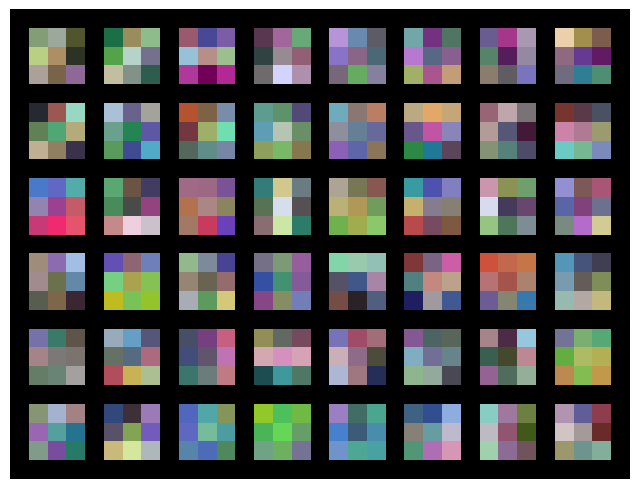

In [ ]:
filter = model.conv1.weight.data.clone()
visualizeTensor(filter)
plt.axis('off')
plt.ioff()
plt.savefig("visualization_image")
plt.show()

# prints out the visualization of the 48 filters from conv1
# Each filter is a 3x3 tensor of different values or colors

In [ ]:
'''
Tuning the number of filters in the convolutional layers and number of neurons in FC layer
these values are currently hard-coded into our model. c1, c1, and l1 and the __init_ method will make our model 
configurable so they aren't limited to only tuning these hyperparameters, 
learning rate and batch size are commonly tuned but tuning them would increase training time
'''
class ConfigNet(nn.Module):
  def __init__(self, l1=256, c1=48, c2=96, d1=0.1):
    super().__init__()
    self.d1 = d1
    self.conv1 = nn.Conv2d(3, c1, 3)
    self.conv2 = nn.Conv2d(c1, c1, 3)
    self.conv3 = nn.Conv2d(c1, c2, 3)
    self.conv4 = nn.Conv2d(c2, c2, 3, stride=2)
    self.flat = nn.Flatten()
    self.batch_norm = nn.BatchNorm1d(c2 * 144)
    self.fc1 = nn.Linear(c2 * 144, l1)
    self.fc2 = nn.Linear(l1, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5)
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConfigNet().to(device)

In [ ]:
search_space = {
    'c1': [48, 96],
    'c2': [96, 192],
    'l1': [256, 512],
}

best_results = {
    'c1': None,
    'c2': None,
    'l1': None,
    'loss': None,
    'acc': 0
}

# dictionary that saves the parameters that give the best results
# using grid search for optimization

In [ ]:
# method that stops the training if training perfomance doesn't show improvement
class EarlyStopping():
    def __init__(self, tolerance=5, verbose=False, path="cifar-tune.pth"):
      self.tolerance = tolerance
      self.counter = 0
      self.early_stop = False
      self.lowest_loss = None
      self.verbose = verbose
      self.path = path

    def step(self, val_loss):
      if (self.lowest_loss == None):
        self.lowest_loss = val_loss
        torch.save(model.state_dict(), self.path)
      elif (val_loss < self.lowest_loss):
        self.lowest_loss = val_loss
        self.counter = 0
        torch.save(model.state_dict(), self.path)
      else:
        if self.verbose:
          print("Early stop counter: {}".format(self.counter+1))
        self.counter +=1
        if self.counter >= self.tolerance:
          self.early_stop = True
          if self.verbose:
            print('Early stopping executed.')

In [ ]:
# Augment Images for the train set essentially creating "new" artifical data
# improves the model's ability to generalize since augmented images will be similar but distinct to the original image
augmented = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Standard transformation for validation set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = CIFAR10(root="cifar",
                        train = True,
                        download = True,
                        transform=augmented)

test_data = CIFAR10(root = "cifar",
                    train = False,
                    download = True,
                    transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Optimization Method
# verbose reports a list to see how each configuration performed after optimization completes and a variable to store the config with the best performance
class HyperSearch():
    def __init__(self, config, verbose=True):
      self.config = config
      self.verbose = verbose
      self.report_list = []
      self.best_results = { 'c1': None,
                            'c2': None,
                            'l1': None,
                            'loss': None,
                            'acc': 0
                            # 'd1': None,
                            # 'lr': None,
                            # 'bsz': None,
                          }

    # Optimization Method
    def optimize(self):
        for l1 in self.config['l1']:
            for c1 in self.config['c1']:
                for c2 in self.config['c2']:
                    early_stopping = EarlyStopping(tolerance=3, verbose=False, path="{}-{}-{}.pth".format(c1, c2, l1))

                    if self.verbose == True:
                        print('Conv1: {} | Conv2: {} | Lin1: {}'.format(str(c1), str(c2), str(l1)))
                    model = ConfigNet(l1=l1, c1=c1, c2=c2).to(device)

                    loss_fn = nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

                    train_dataloader = DataLoader(training_data, batch_size=batch_sz, shuffle=True, num_workers=0)
                    test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

                    epochs = 10
                    for t in range(epochs):
                        if self.verbose == True:
                            print(f"Epoch {t+1}\n-------------------------------")
                        train_loss = train(train_dataloader, model, loss_fn, optimizer, verbose=self.verbose)
                        test_loss, test_acc = test(test_dataloader, model, loss_fn, verbose=self.verbose)

                        # Early Stopping
                        early_stopping.step(test_loss)
                        if early_stopping.early_stop:
                          break
                    print("Done!")
                    self.append_to_report(test_acc, test_loss, c1, c2, l1)

                    if self.best_results['loss'] == None or test_loss < self.best_results['loss']:
                        if self.verbose == True:
                            print("UPDATE: Best loss changed from {} to {}".format(self.best_results['loss'], test_loss))
                        self.best_results.update({
                            'c1': c1,
                            'c2': c2,
                            'loss': test_loss,
                            'l1': l1,
                            'acc': test_acc
                        })
        self.report()

    def report(self):
        print("""
|-----------------------------------------------------------------------------------------------------|
|                                                                                                     |
|                              Report for hyperparameter optimization                                 |
|                                                                                                     |
|-----------------------------------------------------------------------------------------------------|
|    RUN     |              PERFORMANCE             |                   CONFIGURATION                 |
|------------|--------------------------------------|-------------------------------------------------|""")
        for idx, item in enumerate(self.report_list):

            print("|   Run {:02d}   |  Accuracy: {:.2f}%   |   Loss: {:.2f}   |  Conv-1: {}  |  Conv-2: {:3}  |  Linear-1: {:>4}  |".format(idx,
                                                                                                                                       item[0]*100,
                                                                                                                                       item[1],
                                                                                                                                       item[2],
                                                                                                                                       item[3],
                                                                                                                                       item[4]))
            print("|------------|---------------------|----------------|--------------|---------------|------------------|")
        print("\nBest Results | Accuracy: {:.2f}%  |  Loss: {:.2f}  |  Conv-1: {}   |  Conv-2: {}  |  Linear-1: {:>4}  |".format(self.best_results['acc']*100,
                                                                                                                                              self.best_results['loss'],
                                                                                                                                              self.best_results['c1'],
                                                                                                                                              self.best_results['c2'],
                                                                                                                                              self.best_results['l1']))

    def append_to_report(self, acc, loss, c1, c2, l1):
        list_set = (acc, loss, c1, c2, l1)
        self.report_list.append(list_set)

In [ ]:
%%time

lrate=0.001
batch_sz=512

hyper_search = HyperSearch(search_space, verbose=True)

hyper_search.optimize()

Conv1: 48 | Conv2: 96 | Lin1: 256
Epoch 1
-------------------------------
loss: 2.331357  [    0/50000]
loss: 1.689183  [25600/50000]
Test Error: 
 Accuracy: 48.0%, Avg loss: 1.428053 

Epoch 2
-------------------------------
loss: 1.431904  [    0/50000]
loss: 1.421877  [25600/50000]
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.222535 

Epoch 3
-------------------------------
loss: 1.264313  [    0/50000]
loss: 1.192259  [25600/50000]
Test Error: 
 Accuracy: 59.4%, Avg loss: 1.144071 

Epoch 4
-------------------------------
loss: 1.159189  [    0/50000]
loss: 1.124642  [25600/50000]
Test Error: 
 Accuracy: 61.8%, Avg loss: 1.093138 

Epoch 5
-------------------------------
loss: 1.079899  [    0/50000]
loss: 1.021809  [25600/50000]
Test Error: 
 Accuracy: 63.4%, Avg loss: 1.040313 

Epoch 6
-------------------------------
loss: 1.090036  [    0/50000]
loss: 0.940960  [25600/50000]
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.991067 

Epoch 7
-------------------------------
loss: 0.983061

In [ ]:
# lowering learning rate and increasing epochs to improve performance (this and next block)
class ConfigNet(nn.Module):
  def __init__(self, l1=512, c1=48, c2=96, d1=0.1):
    super().__init__()
    self.d1 = d1
    self.conv1 = nn.Conv2d(3, c1, 3)
    self.conv2 = nn.Conv2d(c1, c1, 3)
    self.conv3 = nn.Conv2d(c1, c2, 3)
    self.conv4 = nn.Conv2d(c2, c2, 3, stride=2)
    self.flat = nn.Flatten()
    self.batch_norm = nn.BatchNorm1d(c2 * 144)
    self.fc1 = nn.Linear(c2 * 144, l1)
    self.fc2 = nn.Linear(l1, 10)

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.dropout(x, self.d1)
    x = nn.functional.relu(self.conv3(x))
    x = nn.functional.relu(self.conv4(x))
    x = nn.functional.dropout(x, 0.5)
    x = self.flat(x)
    x = nn.functional.relu(self.batch_norm(x))
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = ConfigNet().to(device)

model = ConfigNet(l1=512, c1=48, c2=96, d1=0.1).to(device)
batch_sz = 512
lrate = 0.0008

In [ ]:
%%time
early_stopping = EarlyStopping(tolerance=6, verbose=True, path="cifar-optimized-test.pth")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

train_dataloader = DataLoader(training_data, batch_size=batch_sz, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=True, num_workers=0)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)

    # Early Stopping
    early_stopping.step(test_loss)
    if early_stopping.early_stop:
      break
print("Done!")

Epoch 1
-------------------------------
loss: 2.310598  [    0/50000]
loss: 1.596375  [25600/50000]
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.494017 

Epoch 2
-------------------------------
loss: 1.474286  [    0/50000]
loss: 1.383046  [25600/50000]
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.308666 

Epoch 3
-------------------------------
loss: 1.315603  [    0/50000]
loss: 1.221366  [25600/50000]
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.185412 

Epoch 4
-------------------------------
loss: 1.083843  [    0/50000]
loss: 1.144974  [25600/50000]
Test Error: 
 Accuracy: 62.1%, Avg loss: 1.072359 

Epoch 5
-------------------------------
loss: 1.058015  [    0/50000]
loss: 1.107028  [25600/50000]
Test Error: 
 Accuracy: 64.1%, Avg loss: 1.009594 

Epoch 6
-------------------------------
loss: 1.066624  [    0/50000]
loss: 1.027432  [25600/50000]
Test Error: 
 Accuracy: 65.7%, Avg loss: 0.983837 

Epoch 7
-------------------------------
loss: 1.017508  [    0/50000]
loss: 0.926574  [2

In [ ]:
# Calculates average test accuracy and loss of all 10 classes
model = ConfigNet(l1=512, c1=48, c2=96, d1=0.1).to(device)
model.load_state_dict(torch.load("cifar-optimized-test.pth"))

loss_fn = nn.CrossEntropyLoss()
batch_sz = 512

test_dataloader = DataLoader(test_data, batch_size=batch_sz, shuffle=False, num_workers=0)
classes = test_data.classes

In [ ]:
test_loss, test_acc = test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.686757 



In [ ]:
# Displays accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0  for classname in classes}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)

    for label,prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

for classname in classes:
    print(f'{classname:5s} Correct Preditcions {correct_pred[classname]}') #possibly prints the classes and their correct predictions
    print(f'{classname:5s} Total Preditcions {total_pred[classname]}') #possibly prints the sum of the column of the class

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

Accuracy for class airplane: 88.2%
Accuracy for class automobile: 82.8%
Accuracy for class bird : 54.8%
Accuracy for class cat  : 45.8%
Accuracy for class deer : 65.4%
Accuracy for class dog  : 75.0%
Accuracy for class frog : 57.9%
Accuracy for class horse: 88.9%
Accuracy for class ship : 73.3%
Accuracy for class truck: 83.3%


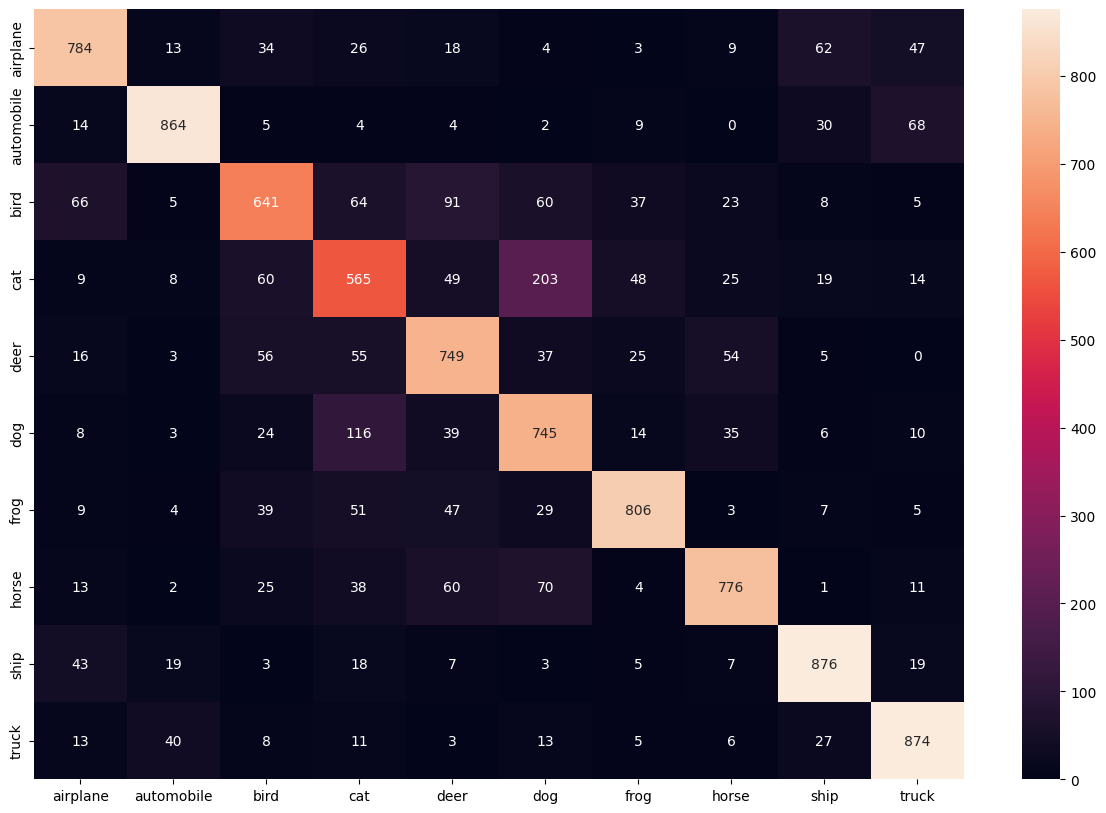

In [ ]:
# Confusion Matrix
num_classes = 10

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


plt.figure(figsize=(15,10))
cf_dataframe = pd.DataFrame(np.array(confusion_matrix, dtype='int'), index=test_data.classes, columns=test_data.classes)
heatmap = sns.heatmap(cf_dataframe, annot=True, fmt='g')
plt.savefig('confusion_matrix')
plt.show()

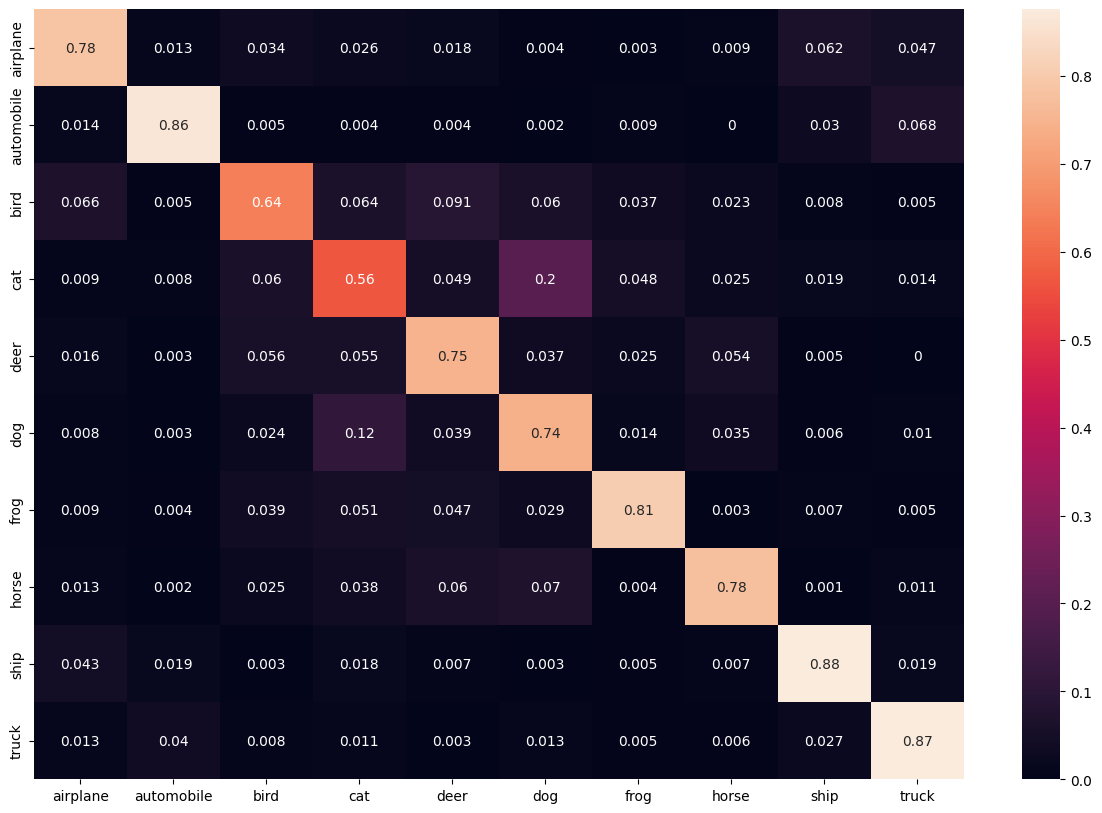

In [ ]:
# Recall per class
cf = np.array(confusion_matrix)
norm_cf = cf / cf.astype(float).sum(axis=1)

plt.figure(figsize=(15,10))
cf_dataframe = pd.DataFrame(np.array(norm_cf, dtype='float64'), index=test_data.classes, columns=test_data.classes).astype(float)
heatmap = sns.heatmap(cf_dataframe, annot=True)

plt.savefig('recall_heat_map')
plt.show()

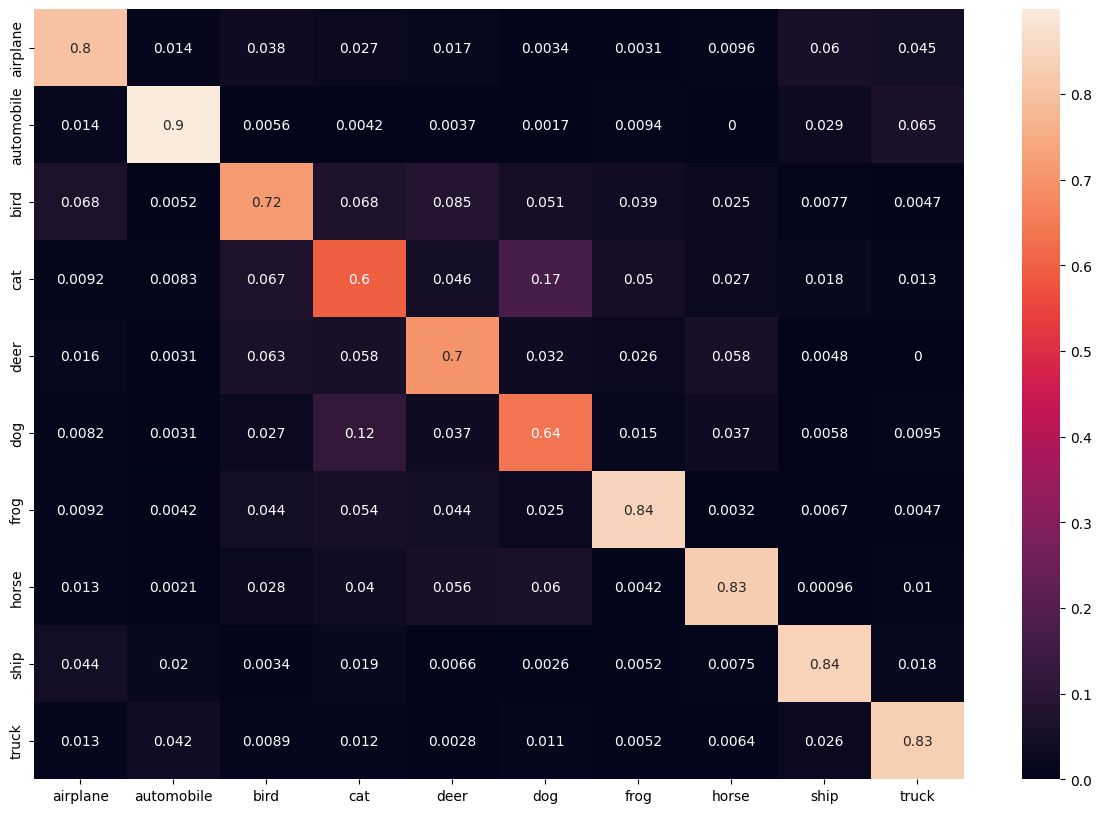

In [ ]:
# Precision per class

cf = np.array(confusion_matrix)
norm_cf = cf / cf.astype(float).sum(axis=0)

plt.figure(figsize=(15,10))
cf_dataframe = pd.DataFrame(np.array(norm_cf, dtype='float64'), index=test_data.classes, columns=test_data.classes).astype(float)
heatmap = sns.heatmap(cf_dataframe, annot=True)

plt.savefig('precision_heat_map')

plt.show()